In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import tqdm
import numpy as np

In [2]:
gtf_path = '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/apa_kd_data_graveley/refs/gencode.v43.annotation.gtf'

In [3]:
gtf_df = pd.read_csv(gtf_path, sep='\t', comment='#',header=None)
gtf_df = gtf_df[gtf_df[2]=='transcript']
gtf_df['transcript_id'] = gtf_df.apply(lambda x: x[8].split(';')[1].split('\"')[1], axis=1)
gtf_df['gene_id'] = gtf_df.apply(lambda x: x[8].split(';')[0].split('\"')[1].split('.')[0], axis=1)
gtf_df['gene_name'] = gtf_df.apply(lambda x: x[8].split(';')[3].split('\"')[1], axis=1)
gene_id_gene_name = dict(zip(gtf_df.gene_id, gtf_df.gene_name))
gene_name_gene_id = dict(zip(gtf_df.gene_name, gtf_df.gene_id))
transcript_id_gene_name = dict(zip(gtf_df.transcript_id, gtf_df.gene_name))
transcript_id_gene_id = dict(zip(gtf_df.transcript_id, gtf_df.gene_id))

In [14]:
salmon_path = '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/apa_kd_data_graveley_redo/salmon_out'

In [15]:
sequenced_samples = set([i.split('/')[-1].split('-')[0] for i in glob.glob(os.path.join(salmon_path, '*.sf'))])

In [16]:
candidates_list = pd.read_csv('./candidate_list.txt', header=None)[0].tolist()

In [17]:
remove_candidates = ['GTSF1']

In [18]:
final_candidate_list = list((set(candidates_list).intersection(sequenced_samples)) - set(remove_candidates))

In [19]:
final_candidate_list = final_candidate_list + ['NUDT21', 'CPSF6']

In [22]:
#counts from all samples
count_matrix = pd.read_csv('count_matrix.txt', sep='\t', index_col=0).dropna()

In [23]:
count_matrix.head()

,ZC3HAV1-BG293LV06-35,HNRNPF-BG293LV06-55,TPD52L2-BG293LV06-83B,LGALS3-BG293LV06-25,LUC7L-BG293LV06-103B,HNRNPH2-BG293LV06-72B,EIF4B-BG293LV06-16,ZMAT3-BG293LV06-79B,DDX17-BG293LV06-116B,RBM42-BG293LV06-86B,...,MBNL1-BG293LV06-17,LSM10-BG293LV06-66B,YWHAG-BG293LV06-75B,PARN-BG293LV06-27,MBNL2-BG293LV06-14,TOB2-BG293LV06-117B,SRP68-BG293LV06-53,TRNAU1AP-BG293LV06-32B,SMNDC1-BG293LV06-92B,LGALS3-BG293LV06-26
gene_name,,,,,,,,,,,,,,,,,,,,,
A1BG,12.0,16.0,22.0,14.000,11.001,13.0,15.944,16.063,23.415,15.199,...,18.0,10.972,34.335,18.289,10.0,12.007,15.002,22.021,21.928,3.006
A1CF,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,...,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000
A2M,1.0,0.0,0.0,0.000,1.000,0.0,0.000,0.000,0.000,0.000,...,0.0,0.000,2.000,1.000,0.0,0.000,0.000,2.000,0.000,0.000
A2ML1,5.0,7.0,16.0,4.002,3.944,4.0,3.000,15.000,7.008,7.000,...,3.0,2.000,4.140,4.000,5.0,5.000,9.000,6.000,5.000,5.297
A3GALT2,0.0,0.0,0.0,1.000,0.000,0.0,1.000,1.000,0.000,0.000,...,0.0,0.000,0.000,0.000,2.0,1.000,0.000,0.000,0.000,0.000


In [24]:
all_rbps = set([i.split('-')[0] for i in count_matrix.columns])

In [28]:
# Determined from thresholding analysis
read_filter =50

In [29]:
read_thresholded_genes_as = {}
for rbp in all_rbps:
    subset_cm = count_matrix[[i for i in count_matrix.columns if rbp in i]]
    read_thresholded_genes_as[rbp] = subset_cm[(subset_cm.iloc[:, 0] > read_filter) & (subset_cm.iloc[:, 1] > read_filter)].index.tolist()


#### Read in AS analysis

In [41]:
table_dir = '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/apa_kd_data_graveley_redo/dif_as'

In [42]:
AS_dict = {}
for path in glob.glob(os.path.join(table_dir, '*/*.JC.txt')):
    rbp = path.split('/')[-2]
    if rbp in final_candidate_list:
        if rbp not in AS_dict:
            AS_dict[rbp] = {}
        event_type = path.split('/')[-1].split('.')[0]
        read_df = pd.read_csv(path, sep='\t')[['geneSymbol', 'PValue', 'FDR', 'IncLevelDifference']]
        read_df = read_df[(read_df['geneSymbol'].isin(set(read_thresholded_genes_as[rbp]).intersection(set(read_thresholded_genes_as['NT']))))  & (read_df['FDR'] < 0.5) & (np.abs(read_df['IncLevelDifference'])> 0.2)]
        read_df['|IncLevelDifference|'] = np.abs(read_df['IncLevelDifference'])
        AS_dict[rbp][event_type] = read_df

In [43]:
AS_df = []
for c in AS_dict:
    c_data = [c]
    for e in ['SE', 'A5SS', 'A3SS', 'RI']:
        if e in AS_dict[c]:
            c_data.append(AS_dict[c][e][(AS_dict[c][e]['FDR'] <0.5) & (np.abs(AS_dict[c][e]['IncLevelDifference']) > 0.2)].drop_duplicates(subset='geneSymbol').shape[0])
        else:
            c_data.append(0)
    AS_df.append(c_data)

In [44]:
sig_AS = {}
for rbp in AS_dict:
    sig_genes = []
    for event in AS_dict[rbp]:
        sig_genes += AS_dict[rbp][event]['geneSymbol'].tolist()
    sig_AS[rbp] = list(set(sig_genes))

In [45]:
AS = pd.DataFrame(AS_df, columns=['candidate','SE', 'A5SS', 'A3SS', 'RI'])

In [46]:
AS.head()

,candidate,SE,A5SS,A3SS,RI
0,WDR6,859,136,178,294
1,EIF4B,575,80,121,181
2,RBM14,838,106,138,216
3,LSM10,659,110,110,177
4,PRRC2B,1354,185,175,255


In [47]:
AS_subset = AS[AS['candidate'].isin(final_candidate_list)]

In [48]:
AS_subset = AS_subset.set_index('candidate')

In [49]:
colorblind_palette = ["#0072B2", "#D55E00", "#CC79A7", "#F0E442", "#009E73"]

In [50]:
AS_subset.head(5)

,SE,A5SS,A3SS,RI
candidate,,,,
WDR6,859,136,178,294
EIF4B,575,80,121,181
RBM14,838,106,138,216
LSM10,659,110,110,177
PRRC2B,1354,185,175,255


#### Read in PAS-seq analysis

In [51]:
pas_dir = '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/apa_kd_data_graveley_redo/dif_apa/pas_seq'

In [52]:
def return_class(df):
    if df['log(treatment.p/treatment.d)'] > df['log(Ctrl.p/Ctrl.d)']:
        return 'proximal'
    elif df['log(treatment.p/treatment.d)'] < df['log(Ctrl.p/Ctrl.d)']:
        return 'distal'

def calc_pas_ratio(df):
    return df['log(treatment.p/treatment.d)'] - df['log(Ctrl.p/Ctrl.d)']

In [53]:
sig_PAS_events = {}
sig_PAS = {}
for rbp_table in glob.glob(os.path.join(pas_dir, '*_APA_table.txt')):
    test = pd.read_csv(rbp_table, sep='\t')
    test['treatment.p + 1'] = test['treatment.p'] + 1
    test['treatment.d + 1'] = test['treatment.d'] + 1
    test['Ctrl.p + 1'] = test['Ctrl.p'] + 1
    test['Ctrl.d + 1'] = test['Ctrl.d'] + 1
    test['log(treatment.p/treatment.d)'] = test.apply(lambda x: np.log2(x['treatment.p + 1']/x['treatment.d + 1']), axis=1)
    test['log(Ctrl.p/Ctrl.d)'] = test.apply(lambda x: np.log2(x['Ctrl.p + 1']/x['Ctrl.d + 1']), axis=1)
    test['dif'] = test.apply(calc_pas_ratio, axis=1)
    test['apa_class'] = test.apply(return_class, axis=1)
    test['apa_type'] = test.apply(lambda x: f"{x['TYPE.p']}_{x['TYPE.d']}", axis=1)
    test = test[test['apa_type'].isin(['LastExon_LastExon', 'Intron_LastExon','Intron_Intron'])]
    sig_PAS_events[ rbp_table.split('/')[-1].split('_')[1]] = test
    sig_PAS[ rbp_table.split('/')[-1].split('_')[1]] =test['SYMBOL'].tolist()

In [54]:
lengthening = []
shortening = []
rbp_list = []
for key in sig_PAS_events:
    if key in final_candidate_list:
        num_distal = sig_PAS_events[key][sig_PAS_events[key]['apa_class']=='distal'].shape[0]
        num_proximal = sig_PAS_events[key][sig_PAS_events[key]['apa_class']=='proximal'].shape[0]
        lengthening.append(num_distal)
        shortening.append(-num_proximal)
        rbp_list.append(key)

In [55]:
passeq_events = pd.DataFrame([rbp_list, lengthening, shortening], ['RBP', 'distal', 'proximal']).T

In [56]:
passeq_events.sort_values(by='proximal', ascending=True).head(10)

,RBP,distal,proximal
32,NUDT21,214,-2152
29,HNRNPF,121,-1321
2,RBM5,19,-803
38,CPSF6,56,-642
24,PPIA,136,-468
14,TRNAU1AP,428,-456
11,RPS19BP1,6,-343
4,TPD52L2,58,-243
6,MBNL2,798,-225
13,ZC3HAV1,339,-193


/tmp/ipykernel_1156550/3177552860.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


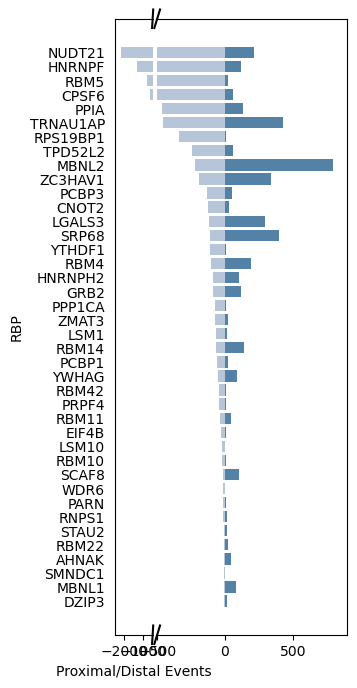

In [57]:
# Create figure with two subplots (broken axis)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [1, 5], 'wspace': 0.04})
fig.set_size_inches(3, 8)

# Plot the smaller values on the first axis
sns.barplot(
    data=passeq_events.sort_values(by='proximal', ascending=True),
    y='RBP', x='proximal', color='lightsteelblue', ax=ax1
)
sns.barplot(
    data=passeq_events.sort_values(by='proximal', ascending=True),
    y='RBP', x='distal', color='steelblue', ax=ax1
)
ax1.set_xlim(-2500, -500)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='y', left=False)

# Plot the larger values on the second axis
sns.barplot(
    data=passeq_events.sort_values(by='proximal', ascending=True),
    y='RBP', x='proximal', color='lightsteelblue', ax=ax2
)
sns.barplot(
    data=passeq_events.sort_values(by='proximal', ascending=True),
    y='RBP', x='distal', color='steelblue', ax=ax2
)
ax2.set_xlim(-500, 900)
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_visible(False)

# Add a break indicator between the two axes
d = 0.015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)

# Add axis labels
ax1.set_xlabel('Proximal/Distal Events')
ax1.set_ylabel('RBP')
ax2.set_xlabel('')

plt.tight_layout()
# plt.savefig('./figures/passeq_distal_prox_counts_barplot_allpas_wbreak.png')
# plt.savefig('./figures/passeq_distal_prox_counts_barplot_allpas_wbreak.jpg')
# plt.savefig('./figures/passeq_distal_prox_counts_barplot_allpas_wbreak.svg')

plt.show()

In [60]:
def jaccard_similarity(set1, set2):
    # intersection of two sets
    intersection = len(set1.intersection(set2))
    # Unions of two sets
    union = len(set1.union(set2))

    #print(intersection, union)
    return intersection / union


In [61]:
rbp_list = []
ji_list = []
for rbp in final_candidate_list:
    if rbp in sig_PAS:
        set_a = set(sig_AS[rbp])
        set_b = set(sig_PAS[rbp])
     
        similarity = jaccard_similarity(set_a, set_b)
        #print(len(set_a), len(set_b))
        rbp_list.append(rbp)
        ji_list.append(similarity)
        


In [62]:
ji_df = pd.DataFrame([rbp_list,ji_list], index=['RBP', 'JI']).T.sort_values(by='JI', ascending=False).set_index('RBP')


In [63]:
#AS_subset = AS_subset.loc[ji_order]

<Axes: ylabel='candidate'>

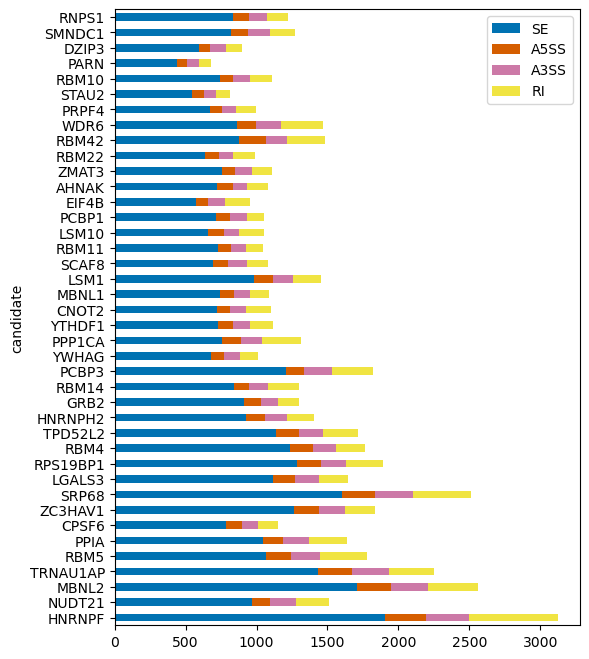

In [64]:
plt.rcParams['figure.figsize'] = [6, 8]
AS_subset.loc[list(ji_df.index)].plot.barh(stacked=True, color=colorblind_palette)
# plt.savefig('./figures/AS_barplot.png')
# plt.savefig('./figures/AS_barplot.svg')
# plt.savefig('./figures/AS_barplot.jpg')

In [71]:
import networkx as nx

In [72]:
protein_network_df = pd.read_csv('../../protein_network_analysis/9606.protein.physical.links.v12.0.txt.gz', sep=' ')

In [73]:
#protein_network_df = protein_network_df[protein_network_df['combined_score']>500]

In [74]:
protein_info = pd.read_csv('../../protein_network_analysis/9606.protein.info.v12.0.txt.gz', sep='\t')
protein_info_dict = dict(zip(protein_info['#string_protein_id'], protein_info['preferred_name']))

In [75]:
protein_network_df['protein1_name'] = protein_network_df.protein1.map(protein_info_dict)

In [76]:
protein_network_df['protein2_name'] = protein_network_df.protein2.map(protein_info_dict)

In [77]:
protein_network_df.head()

,protein1,protein2,combined_score,protein1_name,protein2_name
0,9606.ENSP00000000233,9606.ENSP00000257770,311,ARF5,NT5E
1,9606.ENSP00000000233,9606.ENSP00000226004,161,ARF5,DUSP3
2,9606.ENSP00000000233,9606.ENSP00000434442,499,ARF5,ARFGAP2
3,9606.ENSP00000000233,9606.ENSP00000262455,531,ARF5,ERP44
4,9606.ENSP00000000233,9606.ENSP00000303145,499,ARF5,TMED10


In [78]:
protein_network_df.shape

(1477610, 5)

In [79]:
interest = protein_network_df[(protein_network_df['protein1_name'].isin(final_candidate_list))]

In [80]:
interest_mat = interest.pivot(columns='protein1_name', index='protein2_name', values='combined_score').fillna(0)

In [81]:
interest_mat = interest_mat[[i for i in interest_mat.columns if i in final_candidate_list]]

In [82]:
core_cleavage_polyadenylation_factors = [
    'CPSF1', 'CPSF2', 'CPSF3', 'CPSF4',  # Cleavage and Polyadenylation Specificity Factors
    'CSTF1', 'CSTF2', 'CSTF3',           # Cleavage Stimulation Factors
    'CPSF5', 'CFI68', 'NUDT21',                   # Cleavage Factor I subunits
    'CFII_m', 'PAPOLA', 'PAPOLB',        # Cleavage Factor II and Poly(A) Polymerase
    'PABPN1',                            # Poly(A)-Binding Protein Nuclear 1
    'FIP1L1', 'NUDT21', 'SYMPK',         # Additional auxiliary factors
    'PCF11', 'RBBP6', 'ZNF473',          # Factors associated with transcription termination and polyadenylation
    'WDR33', 'CLP1', 'SYMPK'                    # Other associated proteins
]

In [83]:
core_spliceosome_factors = [
    # U1 snRNP Components
    'U1-70K', 'SNRPA', 'SNRPB', 'SNRPC',
    # U2 snRNP Components
    'SF3A1', 'SF3A2', 'SF3A3', 'SF3B1', 'SF3B2', 'SF3B3', 'SF3B4', 'SF3B5', 'SF3B6', 'SNRPA1', 'SNRPB2',
    # U4/U6-U5 tri-snRNP Components
    'PRPF3', 'PRPF4', 'PRPF6', 'PRPF8', 'PRPF31', 'SNU114', 'EFTUD2',
    # U5 snRNP Components
    'SNRNP200', 'DDX23', 'SNRNP40', 'SNRPB', 'SNRPD1', 'SNRPD2', 'SNRPD3', 'SNRPE', 'SNRPF', 'SNRPG',
    # U6 snRNP Components
    'SNRNP24', 'SNRPD1', 'SNRPD2', 'SNRPD3', 'SNRPE', 'SNRPF', 'SNRPG',
    # Splicing Factors Associated with Spliceosome
    'U2AF1', 'U2AF2', 'SF1', 'SMNDC1', 'CDC5L', 'ISY1', 'SKIP',
    # Other Important Spliceosomal Components
    'PRP19 complex', 'RNF113A', 'SPF45', 'PPIH', 'CWC22',
    # SR Proteins (Serine/Arginine-rich Splicing Factors)
    'SRSF1', 'SRSF2', 'SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7', 'SRSF9',
    # DEAH-box RNA Helicases
    'DHX8', 'DHX15', 'PRP16', 'PRP22', 'PRP43'
]

In [84]:
interest_mat_cpa = interest_mat[interest_mat.index.isin(core_cleavage_polyadenylation_factors)]

In [85]:
nonzero_counts_cpa = interest_mat_cpa.T.apply(lambda row: (row != 0).sum(), axis=1)

In [86]:
interest_mat_splicing = interest_mat[interest_mat.index.isin(core_spliceosome_factors)]

In [87]:
nonzero_counts_splicing = interest_mat_splicing.T.apply(lambda row: (row != 0).sum(), axis=1)

In [88]:
combined_data = pd.concat([ji_df,
 #pd.DataFrame.from_dict(protein_lengths, orient='index'),
 pd.DataFrame(nonzero_counts_cpa),
 pd.DataFrame(nonzero_counts_splicing)], axis=1).dropna()
#combined_data.columns = ['JI', 'protein_length', 'num_CPA', 'num_SP']
combined_data.columns = ['JI', 'num_CPA', 'num_SP']
combined_data['JI'] = combined_data['JI'].astype(float)


In [89]:
import scipy.cluster.hierarchy as sch


{'HNRNPF': '1', 'NUDT21': '5', 'MBNL2': '1', 'TRNAU1AP': '1', 'RBM5': '1', 'PPIA': '3', 'CPSF6': '6', 'ZC3HAV1': '3', 'SRP68': '3', 'LGALS3': '3', 'RPS19BP1': '3', 'RBM4': '3', 'TPD52L2': '3', 'HNRNPH2': '3', 'GRB2': '3', 'RBM14': '4', 'PCBP3': '3', 'YWHAG': '3', 'PPP1CA': '4', 'YTHDF1': '3', 'CNOT2': '3', 'MBNL1': '3', 'LSM1': '2', 'SCAF8': '4', 'RBM11': '3', 'LSM10': '2', 'PCBP1': '2', 'EIF4B': '3', 'AHNAK': '3', 'ZMAT3': '3', 'RBM22': '2', 'RBM42': '2', 'WDR6': '3', 'PRPF4': '2', 'STAU2': '3', 'RBM10': '2', 'PARN': '4', 'DZIP3': '3', 'SMNDC1': '2', 'RNPS1': '2'}
Index(['TRNAU1AP', 'RBM5', 'HNRNPF', 'MBNL2', 'LSM10', 'PRPF4', 'RBM22',
       'RBM42', 'RNPS1', 'LSM1', 'PCBP1', 'RBM10', 'SMNDC1', 'CNOT2', 'PCBP3',
       'YWHAG', 'YTHDF1', 'MBNL1', 'EIF4B', 'RBM11', 'AHNAK', 'ZMAT3', 'STAU2',
       'WDR6', 'DZIP3', 'TPD52L2', 'GRB2', 'PPIA', 'ZC3HAV1', 'RPS19BP1',
       'SRP68', 'LGALS3', 'RBM4', 'HNRNPH2', 'PARN', 'RBM14', 'PPP1CA',
       'SCAF8', 'NUDT21', 'CPSF6'],
      dtype='o

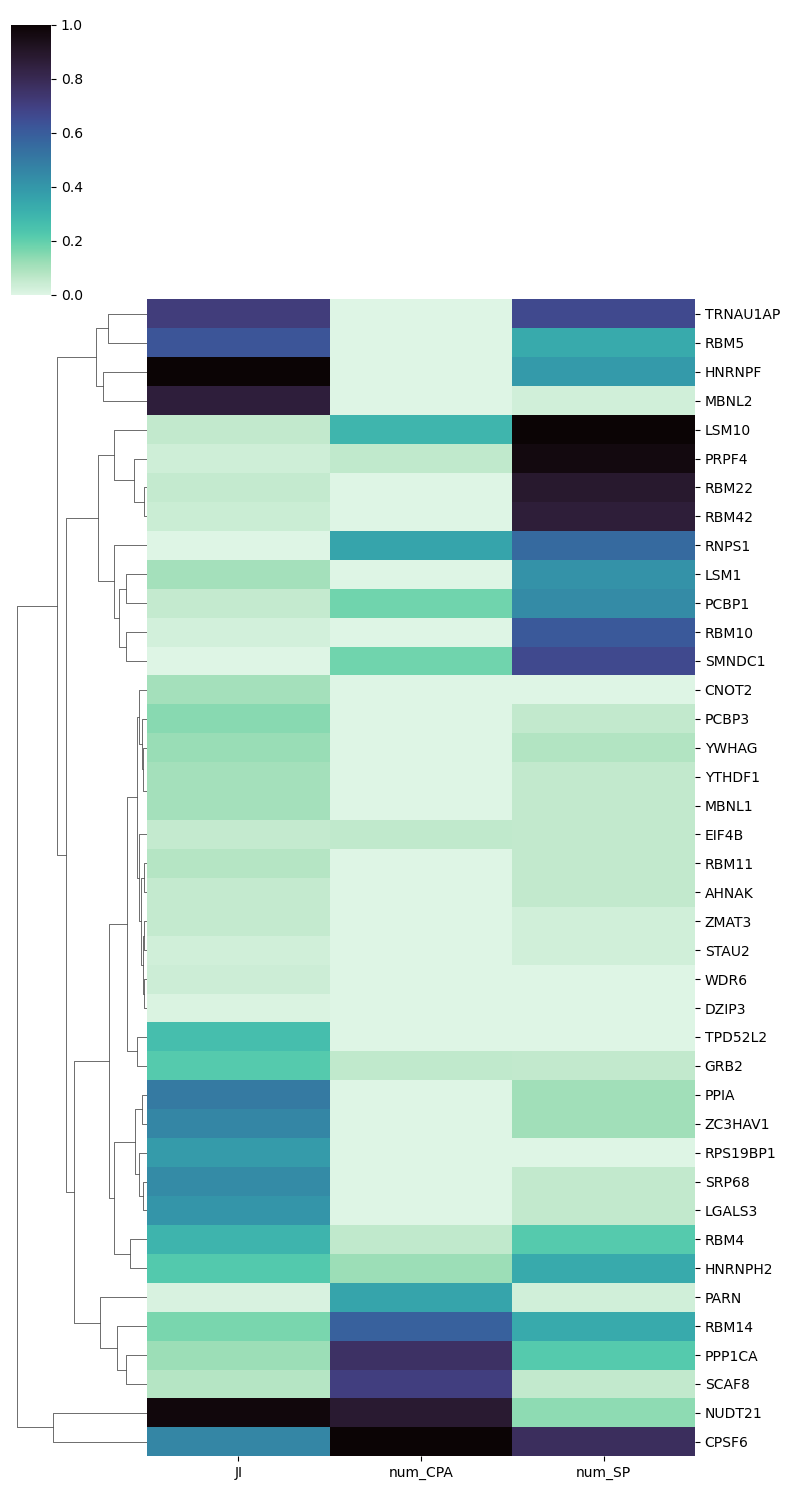

In [90]:
clustermap = sns.clustermap(combined_data, standard_scale=1, col_cluster=False, cmap='mako_r',
              figsize=(8,15))
clustered_row_order = clustermap.dendrogram_row.reordered_ind
clustered_index = combined_data.index[clustered_row_order]

# Get the linkage matrix for the rows (RBPs)
linkage_matrix = clustermap.dendrogram_row.linkage

# Specify the number of clusters
n_clusters = 6# Change to your desired number of clusters

# Assign each RBP to a cluster
cluster_labels = sch.fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

# Create a dictionary mapping RBPs to their clusters
rbp_cluster_dict = {rbp: str(cluster) for rbp, cluster in zip(combined_data.index, cluster_labels)}

# Print the dictionary
print(rbp_cluster_dict)
print(clustered_index)
# plt.savefig('./figures/jaccard_features_clustermap_allpas_noproteinlen.png')
# plt.savefig('./figures/jaccard_features_clustermap_allpas_noproteinlen.svg')
# plt.savefig('./figures/jaccard_features_clustermap_allpas_noproteinlen.jpg')

In [91]:
### THIS CLUSTERING IS USED FOR DOWNSTREAM ANALYSIS
clustered_index

Index(['TRNAU1AP', 'RBM5', 'HNRNPF', 'MBNL2', 'LSM10', 'PRPF4', 'RBM22',
       'RBM42', 'RNPS1', 'LSM1', 'PCBP1', 'RBM10', 'SMNDC1', 'CNOT2', 'PCBP3',
       'YWHAG', 'YTHDF1', 'MBNL1', 'EIF4B', 'RBM11', 'AHNAK', 'ZMAT3', 'STAU2',
       'WDR6', 'DZIP3', 'TPD52L2', 'GRB2', 'PPIA', 'ZC3HAV1', 'RPS19BP1',
       'SRP68', 'LGALS3', 'RBM4', 'HNRNPH2', 'PARN', 'RBM14', 'PPP1CA',
       'SCAF8', 'NUDT21', 'CPSF6'],
      dtype='object')

In [93]:
ji_df['JI'] = ji_df['JI'].astype('float')

<Axes: >

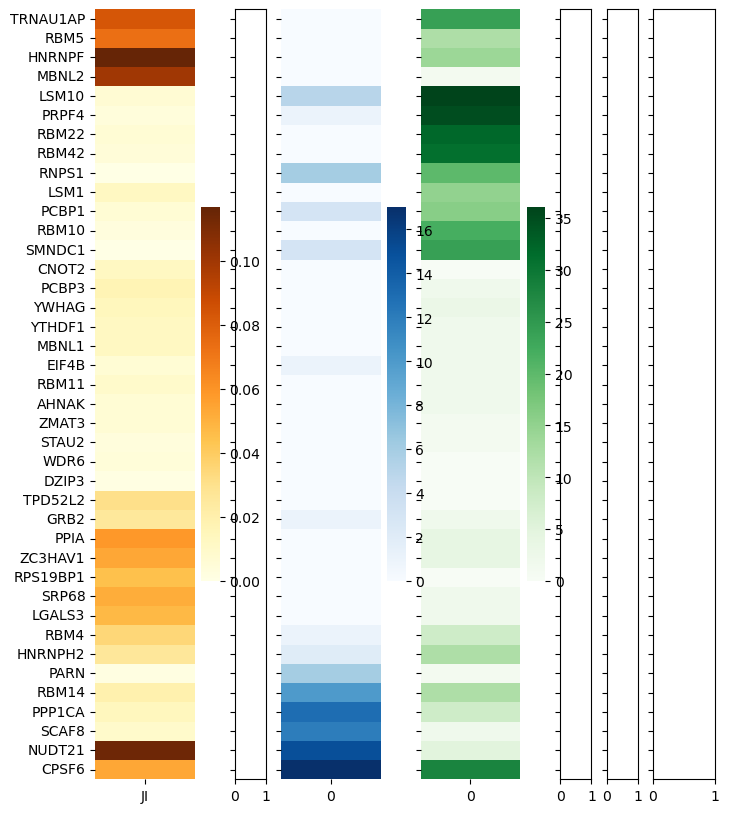

In [96]:
fig, axes = plt.subplots(1, 7, sharey=True,gridspec_kw={'width_ratios': [2,0.5,2,2,0.5,0.5,1]}, figsize=(8,10
                                                                                            ))
sns.heatmap(ji_df.loc[clustered_index], ax=axes[0],cmap='YlOrBr')

sns.heatmap(pd.DataFrame(nonzero_counts_cpa).loc[clustered_index],
            ax=axes[2], cmap='Blues')
sns.heatmap(pd.DataFrame(nonzero_counts_splicing).loc[clustered_index],
            ax=axes[3], cmap='Greens')
# plt.savefig('./figures/jaccard_features_allpasseq_cluster_allheatmaps_noproteinlen_centrality.png')
# plt.savefig('./figures/jaccard_features_allpasseq_cluster_allheatmaps_noproteinlen_centrality.svg')
# plt.savefig('./figures/jaccard_features_allpasseq_cluster_allheatmaps_noproteinlen_centrality.jpg')

In [188]:
clustered_index

Index(['TRNAU1AP', 'RBM5', 'HNRNPF', 'MBNL2', 'LSM10', 'PRPF4', 'RBM22',
       'RBM42', 'RNPS1', 'LSM1', 'PCBP1', 'RBM10', 'SMNDC1', 'CNOT2', 'PCBP3',
       'YWHAG', 'YTHDF1', 'MBNL1', 'EIF4B', 'RBM11', 'AHNAK', 'ZMAT3', 'STAU2',
       'WDR6', 'DZIP3', 'TPD52L2', 'GRB2', 'PPIA', 'ZC3HAV1', 'RPS19BP1',
       'SRP68', 'LGALS3', 'RBM4', 'HNRNPH2', 'PARN', 'RBM14', 'PPP1CA',
       'SCAF8', 'NUDT21', 'CPSF6'],
      dtype='object')